In [13]:
## Imports

import os
# import io
import datetime as dt
import matplotlib.pyplot as plt

plt.close('all')
import numpy as np
import pandas as pd
import geopandas as gpd
import dfm_tools as dfmt

import xarray as xr
import calendar
from scipy.ndimage import convolve, gaussian_filter, label, find_objects
from shapely.geometry import shape, Polygon

from scipy.ndimage import center_of_mass
import matplotlib.dates as mdates

from scipy.spatial.distance import cdist

In [2]:
## Read DCSM:

year = '2012'  
DFM_model = fr'P:\archivedprojects\11209190-029-nose-c-cycling\runs_fine_grid\B05_waq_2012_PCO2_ChlC_NPCratios_test2\DFM_OUTPUT_DCSM-FM_0_5nm_waq'
f = os.path.join(DFM_model, fr"DCSM-FM_0_5nm_waq_0000_map.nc")          # adds a .map file to the base directory
DFM_xr = dfmt.open_partitioned_dataset(f.replace('_0000_','_0*_'))    # opens every .map file in this folder
waq_xr = dfmt.rename_waqvars(DFM_xr)

>> xu.open_dataset() with 256 partition(s): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 : 170.54 sec
>> xu.merge_partitions() wi

In [3]:
# Reading the CMEMS 2012 SPM data

cmem_ss_loc = fr'p:\11209810-cmems-nws\Object_based_validation_MODE\cmems_data'
cmem_ss_file_monthly = os.path.join(cmem_ss_loc, fr"cmems_obs_monthly.nc")
sat_spm = os.path.join(cmem_ss_loc, fr"cmems_obs-oc_glo_bgc-transp_my_l4-multi-4km_P1M_1723800453098.nc")

cmem_monthly_spm = xr.open_dataset(cmem_ss_file_monthly)

In [4]:
# Set output path

basedir = r'P:\11210284-011-nose-c-cycling\validation_method'

outdir = os.path.join(basedir, 'data_export')

In [5]:
# Define the NS extents

x=slice(-12, 10) 
y=slice(50, 55)

x=slice(-5, 10) 
y=slice(50, 58)

x1=slice(-1,10)
y1=slice(50, 56)

longitude=slice(-10, 10) 
latitude=slice(48, 58)

LAT_MIN = 48  # zoom onto the southern North Sea + NL
LAT_MAX = 60
LON_MIN = -10
LON_MAX = 12

In [6]:
# Load EU map extent
eu = gpd.read_file(os.path.join(basedir, 'europe_ns.gpkg'))

In [7]:
# Select SPM variables

model_top_layer = waq_xr.isel(mesh2d_nLayers=49) # Select top layer of the model

suspended_solid = model_top_layer.rename({'mesh2d_SS': 'SPM'}) # Rename to spm
model_spm = suspended_solid['SPM']
cmem_monthly_spm = cmem_monthly_spm['SPM'] # Select SPM from satellite data

# Rename coordinates so it can be used for regridding

cmem_spm = cmem_monthly_spm.rename({'longitude': 'x', 'latitude': 'y'})

In [9]:
# Regrid model data to satellite grid
model_regrided = dfmt.rasterize_ugrid(model_spm, ds_like=cmem_spm)

>> rasterizing ugrid DataArray to shape=(384,576): 15.94 sec


In [10]:
# Remove 2013

model_spm_monthly = model_regrided.sel(time=model_regrided.time.dt.year != 2013)

# Calculate monthly means for the model
model_spm_monthly = model_spm_monthly.resample(time='ME').mean().assign_coords(time=model_spm_monthly.time.resample(time='ME').first())

In [12]:
# Zoom into North Sea region

model_spm_ns = model_spm_monthly.sel(x=longitude, y=latitude)

cmem_spm_ns = cmem_spm.sel(x=longitude, y=latitude)

In [99]:
# Calculate model monthly spm (suspended solids)

for month in range(1, 13):
    month_abb = calendar.month_abbr[month].lower()
    variable_name = f"model_spm_{month_abb}" # create variable for each month
    filtered_data = model_spm_ns.where(model_regrided.time.dt.month.isin([month]), drop=True)
    monthly_mean = filtered_data.mean(dim='time')
    globals()[variable_name] = monthly_mean # Assign each months mean to new variable

# Create variable for each month for CMEM data

for month_int in range(1, 13):
    month_abb = calendar.month_abbr[month_int].lower()
    cmem_variable_name = f"cmem_spm_{month_abb}" # create variable for each month
    filtered_month = cmem_spm.isel(time=month_int-1)
    globals()[cmem_variable_name] = filtered_month

In [24]:
# Zoom into North Sea (January) 

model_spm_jan_ns = model_spm_ns.isel(time=0)

cmem_spm_jan_ns= cmem_spm_ns.isel(time=0)

In [1121]:
model_spm_jan_ns.rename({'x':'longitude', 'y':'latitude'})

<xarray.DataArray 'SPM' (latitude: 240, longitude: 480)> Size: 922kB
dask.array<getitem, shape=(240, 480), dtype=float64, chunksize=(240, 480), chunktype=numpy.ndarray>
Coordinates:
    mesh2d_layer_sigma_z  float64 8B -2.5
    mesh2d_face_y         (latitude, longitude) float64 922kB dask.array<chunksize=(240, 480), meta=np.ndarray>
    mesh2d_face_x         (latitude, longitude) float64 922kB dask.array<chunksize=(240, 480), meta=np.ndarray>
    mesh2d_nFaces         (latitude, longitude) int64 922kB 317624 ... 41682
  * latitude              (latitude) float32 960B 48.02 48.06 ... 57.94 57.98
  * longitude             (longitude) float32 2kB -9.979 -9.938 ... 9.938 9.979

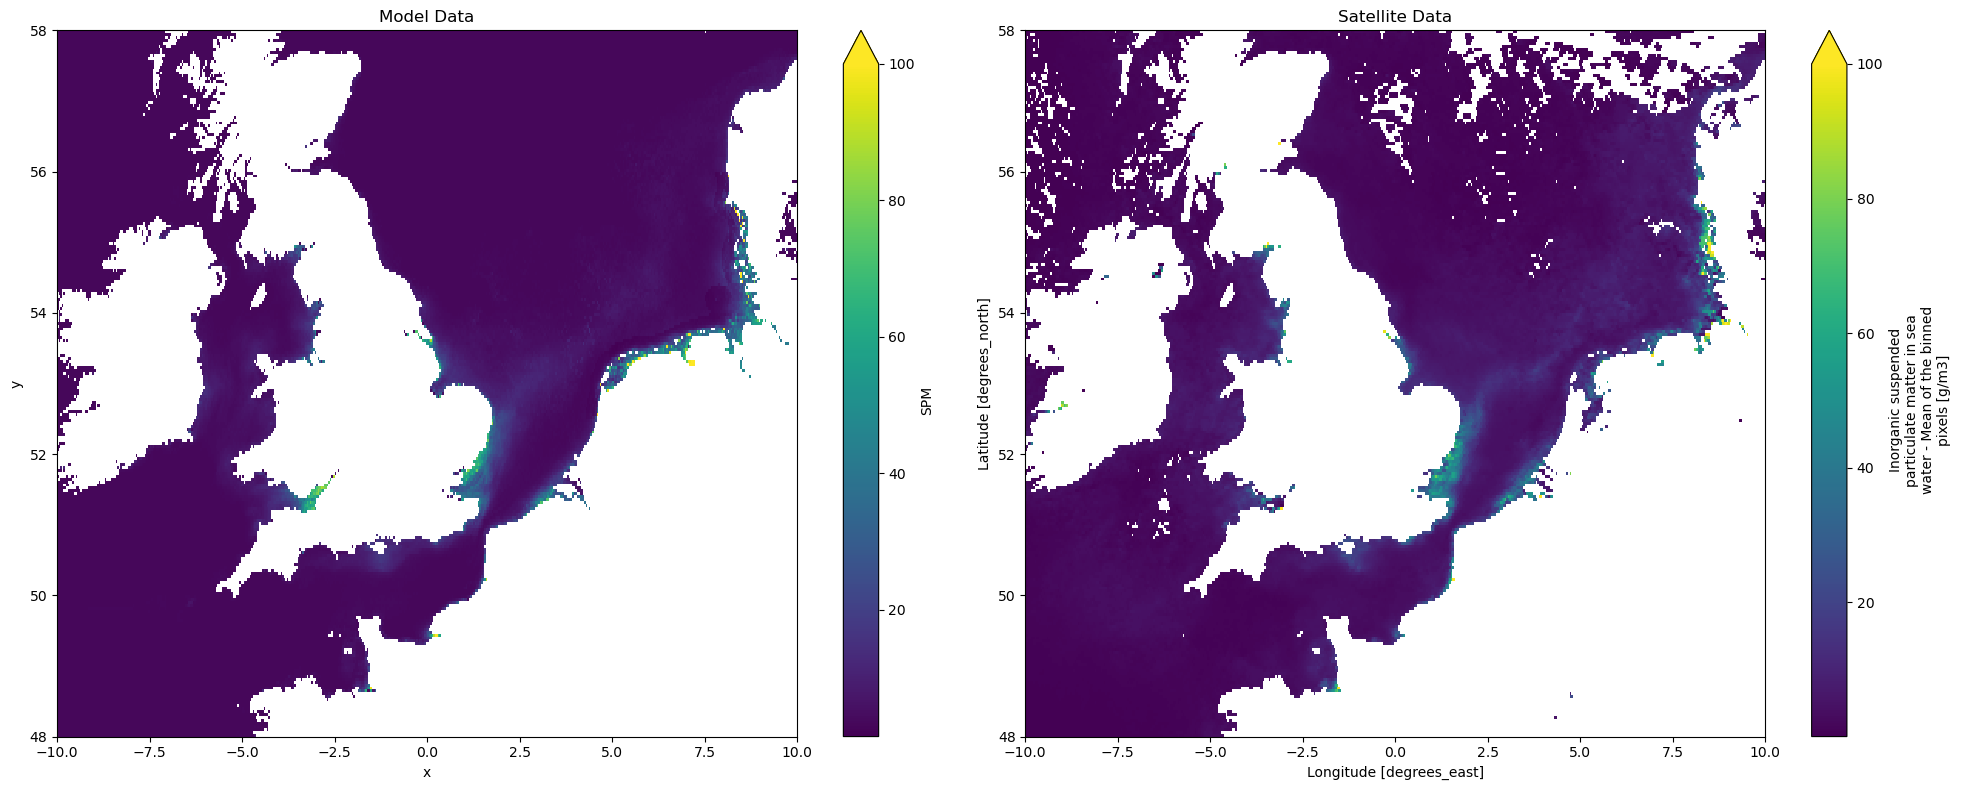

In [21]:
# Plot model and satellite for January

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

model_spm_jan_ns.plot(ax=axes[0], vmax=100)
axes[0].set_title('Model Data')

cmem_spm_jan_ns.plot(ax=axes[1], vmax=100)
axes[1].set_title('Satellite Data')

plt.tight_layout()
plt.show()


In [20]:
# Extract the difference map for model and observation

diff_map = cmem_spm_jan_ns - model_spm_jan_ns

# diff_map.to_netcdf(os.path.join(outdir, fr'diff_map.nc'))

In [ ]:
# Plot a difference map

fig = plt.figure(figsize=(7,10))

diff_map.plot(vmax=20)

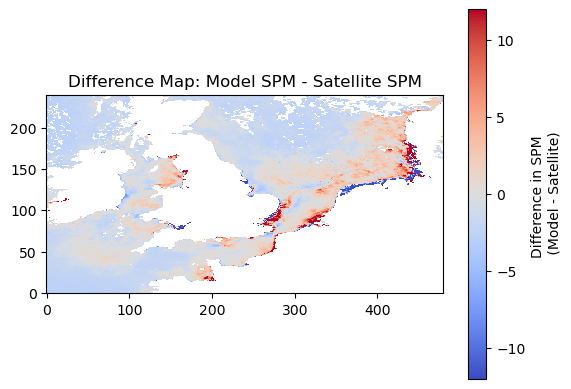

In [27]:
# Difference map

vmin,vmax = -12,12
plt.imshow(diff_map, cmap='coolwarm', vmax=vmax, vmin=vmin, interpolation='none', origin='lower')
plt.colorbar(label='Difference in SPM \n (Model - Satellite)')
plt.title('Difference Map: Model SPM - Satellite SPM')
plt.show()

# MODE (Method for Object-based Diagnostic Evaluation) 

#### Convolution and smoothing

In [22]:
# # Convolution and smoothing the data field with a Gaussian kernel
# 
# # Model convolution
# model_spm_convolution = gaussian_filter(model_spm_ns, sigma=1, radius=1)
# model_spm_convolved = xr.DataArray(model_spm_convolution, dims=model_spm_ns.dims, coords=model_spm_ns.coords)
# 
# # Satellite convolution
# cmem_spm_convolution = gaussian_filter(cmem_spm_ns, sigma=1, radius=1)
# cmem_spm_convolved = xr.DataArray(cmem_spm_convolution, dims=cmem_spm_ns.dims, coords=cmem_spm_ns.coords)

KeyboardInterrupt: 

In [25]:
# Convolution and smoothing the data field with a Gaussian kernel

# Model convolution
model_spm_convolution = gaussian_filter(model_spm_jan_ns, sigma=1, radius=1)
model_spm_convolved = xr.DataArray(model_spm_convolution, dims=model_spm_jan_ns.dims, coords=model_spm_jan_ns.coords)

# Satellite convolution
cmem_spm_convolution = gaussian_filter(cmem_spm_jan_ns, sigma=1, radius=1)
cmem_spm_convolved = xr.DataArray(cmem_spm_convolution, dims=cmem_spm_jan_ns.dims, coords=cmem_spm_jan_ns.coords)


In [30]:
model_spm_convolution

array([[2.97027527, 2.97027614, 2.97027759, ...,        nan,        nan,
               nan],
       [2.97028103, 2.97027853, 2.97027439, ...,        nan,        nan,
               nan],
       [2.97028237, 2.9702706 , 2.97025119, ...,        nan,        nan,
               nan],
       ...,
       [2.957215  , 2.9571551 , 2.95705636, ..., 2.99568874, 2.99478928,
        2.99333183],
       [2.95720196, 2.95714067, 2.95703961, ..., 2.99157063, 2.9920828 ,
        2.99160791],
       [2.95719705, 2.95713542, 2.95703379, ..., 2.98978157, 2.99006678,
        2.99026002]])

In [42]:
model_spm_convolved

<xarray.DataArray (y: 240, x: 480)> Size: 922kB
array([[2.97027527, 2.97027614, 2.97027759, ...,        nan,        nan,
               nan],
       [2.97028103, 2.97027853, 2.97027439, ...,        nan,        nan,
               nan],
       [2.97028237, 2.9702706 , 2.97025119, ...,        nan,        nan,
               nan],
       ...,
       [2.957215  , 2.9571551 , 2.95705636, ..., 2.99568874, 2.99478928,
        2.99333183],
       [2.95720196, 2.95714067, 2.95703961, ..., 2.99157063, 2.9920828 ,
        2.99160791],
       [2.95719705, 2.95713542, 2.95703379, ..., 2.98978157, 2.99006678,
        2.99026002]])
Coordinates:
    mesh2d_layer_sigma_z  float64 8B -2.5
    mesh2d_face_x         (y, x) float64 922kB dask.array<chunksize=(240, 480), meta=np.ndarray>
    mesh2d_face_y         (y, x) float64 922kB dask.array<chunksize=(240, 480), meta=np.ndarray>
    mesh2d_nFaces         (y, x) int64 922kB 317624 317624 ... 41649 41682
  * y                     (y) float32 960B 48.02 48.06 48.1 ... 57.9 57.94 57.98
  * x                     (x) float32 2kB -9.979 -9.938 -9.896 ... 9.938 9.979
    time                  datetime64[ns] 8B 2012-01-01

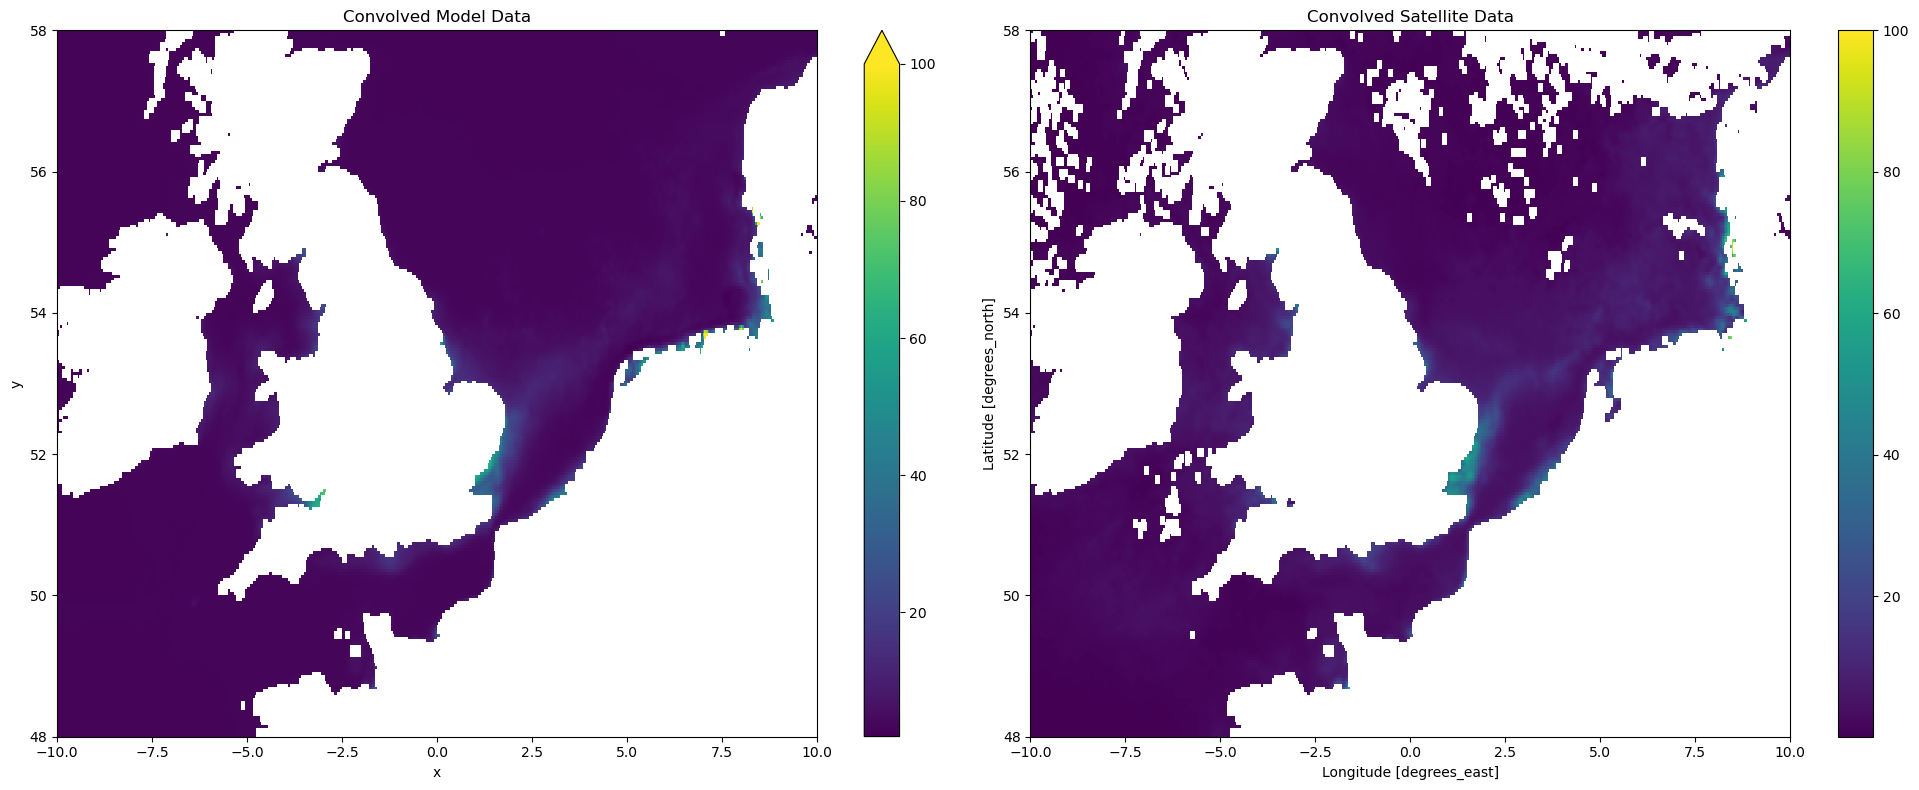

In [27]:
# Plot smoothened model and satellite for January

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

model_spm_convolved.plot(ax=axes[0], vmax=100)
axes[0].set_title('Convolved Model Data')

cmem_spm_convolved.plot(ax=axes[1], vmax=100)
axes[1].set_title('Convolved Satellite Data')

plt.tight_layout()
plt.show()


In [ ]:
# Convolution and smoothing the data with a different method - cylindrical kernel?

# Specify smoothening kernel

# kernal = sci.gaussian
# k = np.array

#Model convolution
# model_spm_convolution = gaussian_filter(model_spm_jan_ns, kernel, mode='constant', cval=0.0)
# model_spm_convolved = xr.DataArray(model_spm_convolution, dims=model_spm_jan_ns.dims, coords=model_spm_jan_ns.coords)
# 
# # Satellite convolution
# cmem_spm_convolution = gaussian_filter(cmem_spm_jan_ns, kernel, mode='constant', cval=0.0)
# cmem_spm_convolved = xr.DataArray(cmem_spm_convolution, dims=cmem_spm_jan_ns.dims, coords=cmem_spm_jan_ns.coords)


#### Step 2: Thresholding

In [38]:
# Thresholding the convolved layer

# Specify threshold values
threshold_value_1 = 7 #
threshold_value_2 = 4 # Lu

model_spm_threshold_1 = model_spm_convolved > threshold_value_1
model_spm_threshold_2 = model_spm_convolved > threshold_value_2

cmem_spm_threshold_1 = cmem_spm_convolved > threshold_value_1
cmem_spm_threshold_2 = cmem_spm_convolved > threshold_value_2

cmem_spm_threshold_1x = cmem_spm_convolved > 10

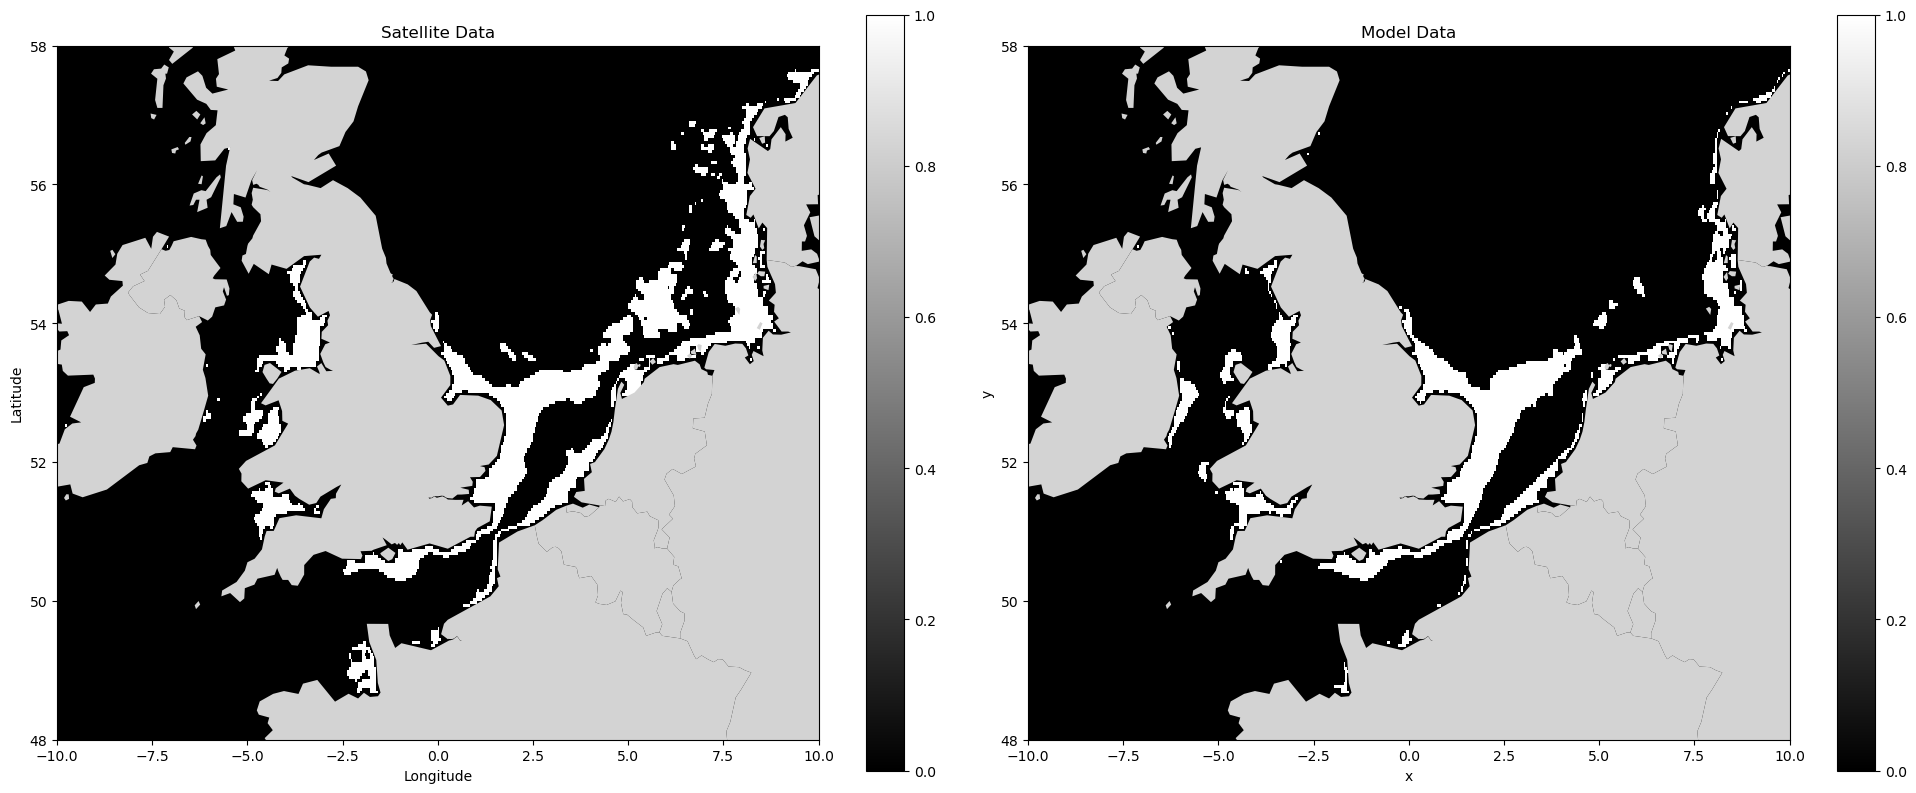

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

cmem_spm_threshold_1.plot(ax=axes[0], cmap='gray')
axes[0].set_title('Satellite Data')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
eu.plot(ax=axes[0], color='lightgrey', linestyle='--')

model_spm_threshold_1.plot(ax=axes[1], cmap='gray')
eu.plot(ax=axes[1], color='lightgrey', linestyle='--')
axes[1].set_title('Model Data')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


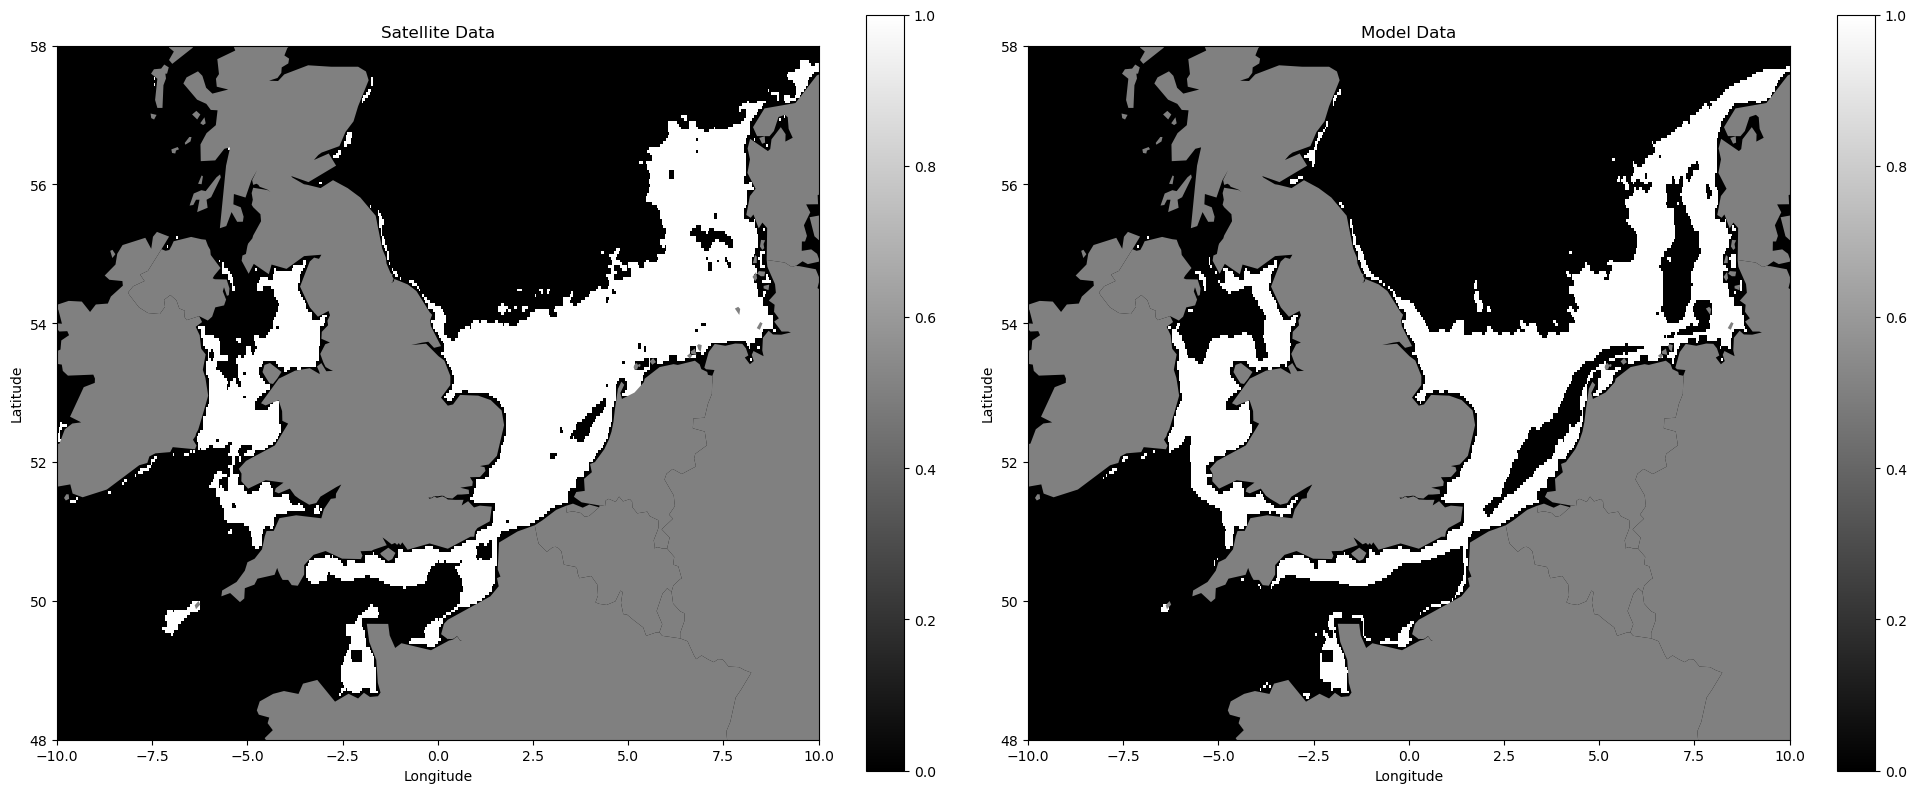

In [43]:
# Plot Threshold 2 Luc et al.

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

cmem_spm_threshold_2.plot(ax=axes[0], cmap='gray')
axes[0].set_title('Satellite Data')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
eu.plot(ax=axes[0], color='gray', linestyle='--')

model_spm_threshold_2.plot(ax=axes[1], cmap='gray')
eu.plot(ax=axes[1], color='gray', linestyle='--')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Model Data')

# plt.title('Object identification (Threshold > 4)')
plt.tight_layout()
plt.show()


In [41]:
# Label similar regions in the thresholded data

model_labeled_data, model_num_features = label(model_spm_threshold_1)

thresholded_model = xr.DataArray(model_spm_threshold_1, dims=cmem_spm_convolved.dims, coords=cmem_spm_convolved.coords)
labeled_model = xr.DataArray(model_labeled_data, dims=cmem_spm_convolved.dims, coords=cmem_spm_convolved.coords)

# For satellite observation

cmem_labeled_data, cmem_num_features = label(cmem_spm_threshold_1)

thresholded_sat = xr.DataArray(cmem_spm_threshold_1, dims=cmem_spm_convolved.dims, coords=cmem_spm_convolved.coords)
labeled_sat = xr.DataArray(cmem_labeled_data, dims=cmem_spm_convolved.dims, coords=cmem_spm_convolved.coords)


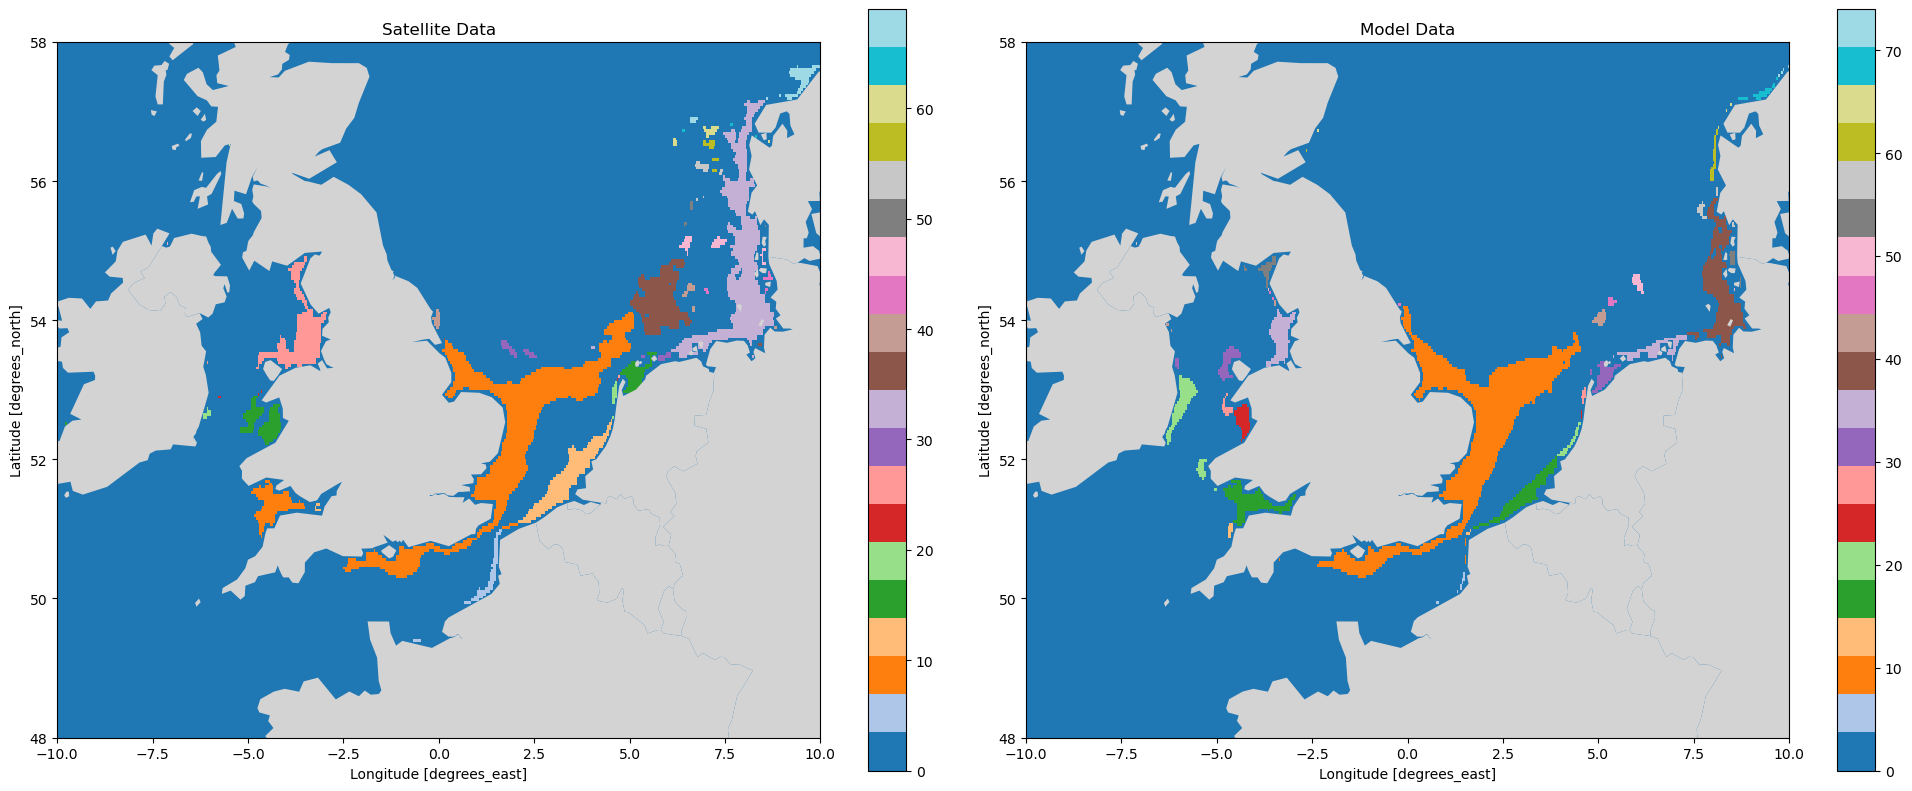

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

labeled_sat.plot(ax=axes[0], cmap='tab20')
axes[0].set_title('Satellite Data')
eu.plot(ax=axes[0], color='lightgrey', linestyle='--')

labeled_model.plot(ax=axes[1], cmap='tab20')
axes[1].set_title('Model Data')
eu.plot(ax=axes[1], color='lightgrey', linestyle='--')


plt.tight_layout()
plt.show()


#### A lot of objects have been identified, smaller objects can be elimated

In [47]:
# Function to remove some small negligible objects

''''
The function takkes theh labeled dataset and the minimum number of pixel to be considered

labeled_image = input label data
min_size = minimum number of pixel to be considered
'''

def remove_small_objects(labeled_image, min_size):

  # labels and their counts
  labels, counts = np.unique(labeled_image, return_counts=True)

  mask = counts[labeled_image] >= min_size

  large_objects = labeled_image * mask

  return large_objects

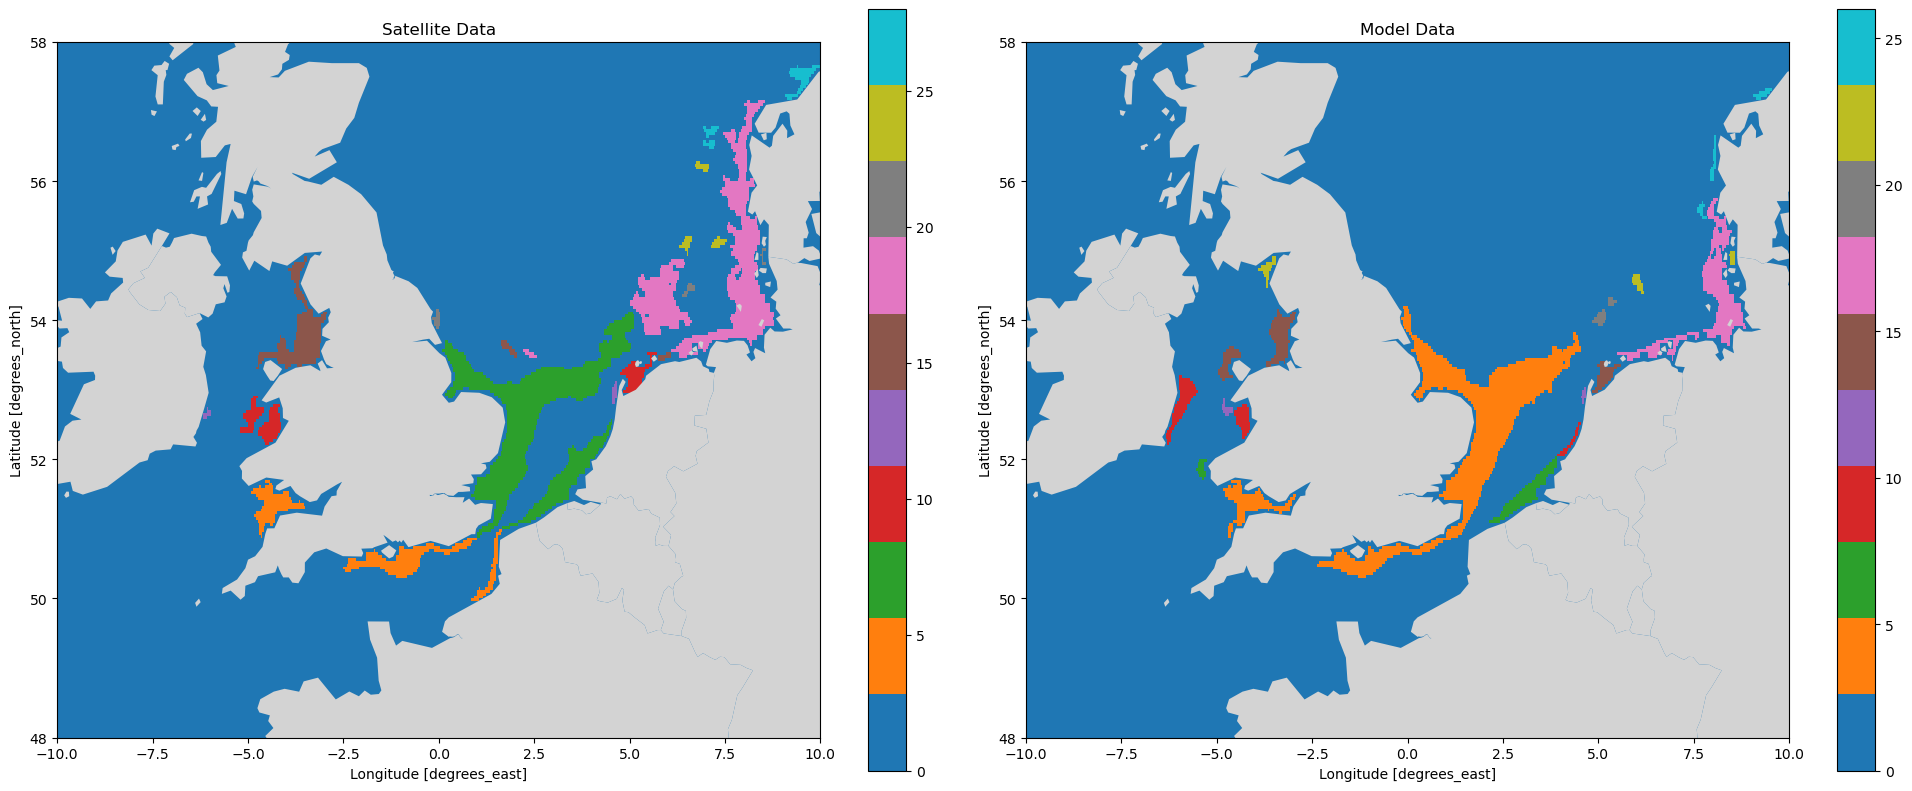

In [258]:
# Extract large objects

model_objects, num_features_mod = label(remove_small_objects(labeled_model, min_size=10))
sat_objects, num_features_sat = label(remove_small_objects(labeled_sat, min_size=10))

# Save back as xarrayDA
model_objects_labeled = xr.DataArray(model_objects, dims=cmem_spm_convolved.dims, coords=cmem_spm_convolved.coords)
sat_objects_labeled = xr.DataArray(sat_objects, dims=cmem_spm_convolved.dims, coords=cmem_spm_convolved.coords)

# Plot the filtered object

figure, axes = plt.subplots(1, 2, figsize=(20, 8))

sat_objects_labeled.plot(ax=axes[0], cmap='tab10')
axes[0].set_title('Satellite Data')
eu.plot(ax=axes[0], color='lightgray', linestyle='--')

model_objects_labeled.plot(ax=axes[1], cmap='tab10')
axes[1].set_title('Model Data')
eu.plot(ax=axes[1], color='lightgray', linestyle='--')



plt.tight_layout()
plt.show()

In [437]:
# Merge nearby objects into simpler feature to create convex hull

#### Calculating object attributes and Mactching Model and Sat objects

Matching can be done using 
 - [x] Distance of their centroids
 - [ ] Fuzzy logic


In [112]:
(sat_objects_labeled.where(sat_objects_labeled.values == 6)).sum()

<xarray.DataArray ()> Size: 8B
array(11556.)
Coordinates:
    time     datetime64[ns] 8B 2012-01-01

## Restore Orignal SPM values

In [58]:
# Restore spm values

def restore_spm_values(labeled_data, original_spm):
    
    object_spm_values = [] # List to store the SPM values for each object
    unique_labels = np.unique(labeled_data)
    
    for label_num in unique_labels:
        if label_num == 0:
            continue  # Skip the background
        
        # Create a mask for the current object
        mask = labeled_data == label_num
        
        # Restore the original SPM values for the current object
        spm_values = original_spm.values[mask]
        
        object_spm_values.append({
            'label': label_num,
            'spm_values': spm_values
        })
    
    return object_spm_values


model_objects_xr = restore_spm_values(model_objects_labeled, model_spm_jan_ns)
sat_objects_xr = restore_spm_values(sat_objects_labeled, cmem_spm_jan_ns)

#### Attribute Calculation

In [135]:

'''
Area: This attribute is a simple measure of an object’s
size. 

Centroid: The centroid is considered as a “center
of mass” for the object. Vector differences between the cen-
troids of forecast and observed objects can reveal
systematic location biases in the forecasts.

Aspect ratio: The ratio of the length of the minor axis 
to the length of the major axis is the aspect ratio. 

Other attributes that could be useful are:
i. Curvature
ii. Axis angle

'''


def calculate_attributes(labeled_data, restored_values):
    attributes = []
    unique_labels = np.unique(labeled_data)

    for label_num in unique_labels:
        if label_num == 0:
            continue  # Skip the background
        
        mask = labeled_data == label_num
        spm_values = restored_values[label_num-1]
        area = mask.sum()
        centroids = np.array(center_of_mass(mask))

        slices = find_objects(labeled_data == label_num)[0]
        y_slice, x_slice = slices
        
        # width and height of the bounding box
        width = x_slice.stop - x_slice.start
        height = y_slice.stop - y_slice.start
        
        # Calculate aspect ratio (width / height)
        aspect_ratio = width / height if height > 0 else 0
        
        mean_spm = np.mean(spm_values['spm_values']) # average spm with object space
        
        attributes.append({
            'object_label': label_num,
            'mean_spm': mean_spm,
            'area': area,
            'centroids': centroids,
            'aspect_ratio':aspect_ratio
        })
    
    return attributes



In [149]:
# Calculate attributes for each object

model_objects_attributes = calculate_attributes(model_objects,model_objects_xr) # Using the original labeled data
sat_objects_attributes = calculate_attributes(sat_objects, sat_objects_xr)

C:\Users\benson\AppData\Local\anaconda3\envs\validation\Lib\site-packages\scipy\ndimage\_measurements.py:309: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
C:\Users\benson\AppData\Local\anaconda3\envs\validation\Lib\site-packages\scipy\ndimage\_measurements.py:309: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
C:\Users\benson\AppData\Local\anaconda3\envs\validation\Lib\site-packages\scipy\ndimage\_measurements.py:309: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
C:\Users\benson\AppData\Local\anaconda3\envs\validation\Lib\site-packages\scipy\ndimage\_measurements.py:309: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an 

#### Matching

In [251]:
# Perform the matching process

def match_objects(model_attrs, satellite_attrs):
    matches = []

    for model_attr in model_attrs:
        Af = model_attr['area']
        model_centroid = model_attr['centroids']
        
        for satellite_attr in satellite_attrs:
            Ao = satellite_attr['area']
            satellite_centroid = satellite_attr['centroids']
            
            # centroid distance 
            D = np.linalg.norm(model_centroid - satellite_centroid)
            
            # Calculate areas
            area_sum = np.sqrt(Af) + np.sqrt(Ao)
            
            # Matching condition
            if D < area_sum:
                matches.append({
                    'model_label': model_attr['object_label'],
                    'model_obj_area': model_attr['area'],
                    'model_mean_spm': model_attr['mean_spm'],
                    
                    'sat_label': satellite_attr['object_label'],
                    'sat_mean_spm': satellite_attr['mean_spm'],
                    'sat_obj_area': satellite_attr['area'],
                    'distance': D,
                })
    
    return matches

In [252]:
# Match objects based on centroid distance and object size
matches = match_objects(model_objects_attributes, sat_objects_attributes)

# Print the matched pairs
for match in matches:
    print(f"Model Object {match['model_label']} matched with Satellite Object {match['sat_label']} | "
          f"Distance: {match['distance']:.2f}")

Model Object 1 matched with Satellite Object 1 | Distance: 7.10
Model Object 2 matched with Satellite Object 2 | Distance: 1.15
Model Object 3 matched with Satellite Object 3 | Distance: 49.76
Model Object 3 matched with Satellite Object 6 | Distance: 20.11
Model Object 3 matched with Satellite Object 7 | Distance: 33.08
Model Object 3 matched with Satellite Object 8 | Distance: 44.09
Model Object 3 matched with Satellite Object 16 | Distance: 28.89
Model Object 3 matched with Satellite Object 17 | Distance: 31.96
Model Object 4 matched with Satellite Object 5 | Distance: 11.20
Model Object 5 matched with Satellite Object 5 | Distance: 6.42
Model Object 6 matched with Satellite Object 6 | Distance: 33.75
Model Object 6 matched with Satellite Object 8 | Distance: 8.20
Model Object 8 matched with Satellite Object 6 | Distance: 45.49
Model Object 8 matched with Satellite Object 8 | Distance: 24.31
Model Object 9 matched with Satellite Object 12 | Distance: 5.25
Model Object 10 matched wit

In [253]:
''''
Find best first match based on distance since the orignal matches are duplicated
'''''

def best_matches(model_objects_attributes, sat_objects_attributes):
    best_matches_dict = {}
    
    matches = match_objects(model_objects_attributes, sat_objects_attributes)
    
    matches.sort(key=lambda x: x['distance']) # Sort matches by distance
    for match in matches:
        model_label = match['model_label']

        if model_label not in best_matches_dict:
            best_matches_dict[model_label] = match

    best_matches = list(best_matches_dict.values()) 
    
    return best_matches



In [254]:

best_match = best_matches(model_objects_attributes, sat_objects_attributes)

for match in best_match:
    print(f"Model Object {match['model_label']} matched with Satellite Object {match['sat_label']} | "
          f"Distance: {match['distance']:.2f}")

Model Object 23 matched with Satellite Object 22 | Distance: 0.64
Model Object 12 matched with Satellite Object 13 | Distance: 0.78
Model Object 2 matched with Satellite Object 2 | Distance: 1.15
Model Object 10 matched with Satellite Object 9 | Distance: 2.87
Model Object 13 matched with Satellite Object 11 | Distance: 4.06
Model Object 11 matched with Satellite Object 10 | Distance: 4.42
Model Object 9 matched with Satellite Object 12 | Distance: 5.25
Model Object 5 matched with Satellite Object 5 | Distance: 6.42
Model Object 1 matched with Satellite Object 1 | Distance: 7.10
Model Object 26 matched with Satellite Object 28 | Distance: 7.28
Model Object 15 matched with Satellite Object 14 | Distance: 7.86
Model Object 6 matched with Satellite Object 8 | Distance: 8.20
Model Object 21 matched with Satellite Object 19 | Distance: 8.22
Model Object 20 matched with Satellite Object 19 | Distance: 10.95
Model Object 4 matched with Satellite Object 5 | Distance: 11.20
Model Object 17 matc

In [255]:
# Save to dataframe

match_df = pd.DataFrame(best_match)
match_df['area_diff'] = match_df['sat_obj_area'] - match_df['model_obj_area']
# match_df.sort_values(by=['distance'], ascending=True, inplace=True)

match_df

,model_label,model_obj_area,model_mean_spm,sat_label,sat_mean_spm,sat_obj_area,distance,area_diff
0,23,16,36.443276,22,78.380562,11,0.640334,-5
1,12,10,10.387036,13,9.319956,19,0.776115,9
2,2,24,12.501848,2,13.272714,27,1.152815,3
3,10,75,8.138263,9,8.204638,117,2.865388,42
4,13,79,27.621671,11,14.481587,185,4.056328,106
5,11,20,7.778755,10,7.917103,84,4.419333,64
6,9,144,8.913308,12,7.602350,11,5.254885,-133
7,5,231,18.579477,5,11.694796,236,6.422263,5
8,1,28,11.447503,1,10.086482,176,7.099822,148
9,26,23,7.710921,28,8.591510,90,7.275910,67


<Axes: title={'center': 'Model Data'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

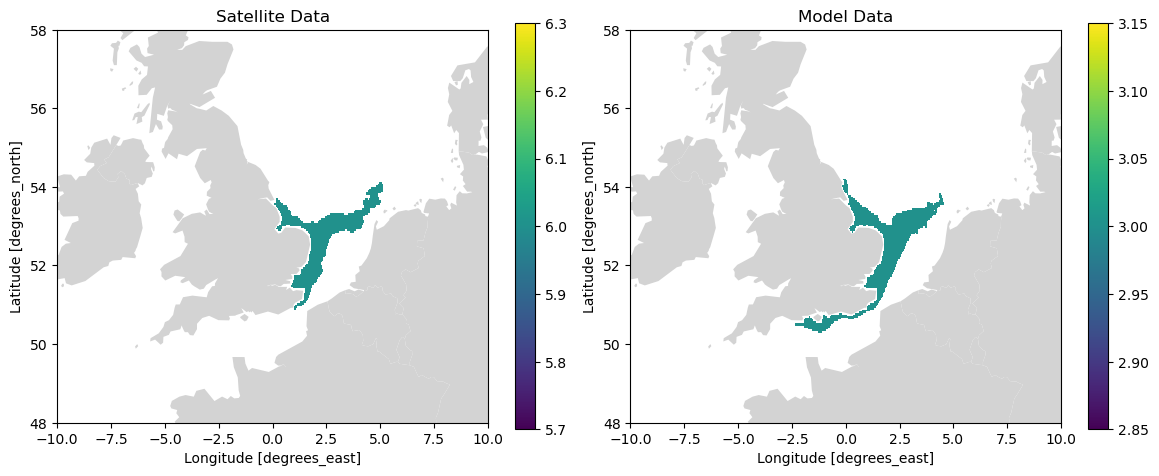

In [221]:
# Plot some matches
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sat_objects_labeled.where(sat_objects_labeled == 6).plot(ax=axes[0])
axes[0].set_title('Satellite Data')
plt.tight_layout()
eu.plot(ax=axes[0], color='lightgrey', linestyle='--')

model_objects_labeled.where((model_objects_labeled) == 3).plot(ax=axes[1])
axes[1].set_title('Model Data')
eu.plot(ax=axes[1], color='lightgrey', linestyle='--')

<Axes: title={'center': 'Model Data'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

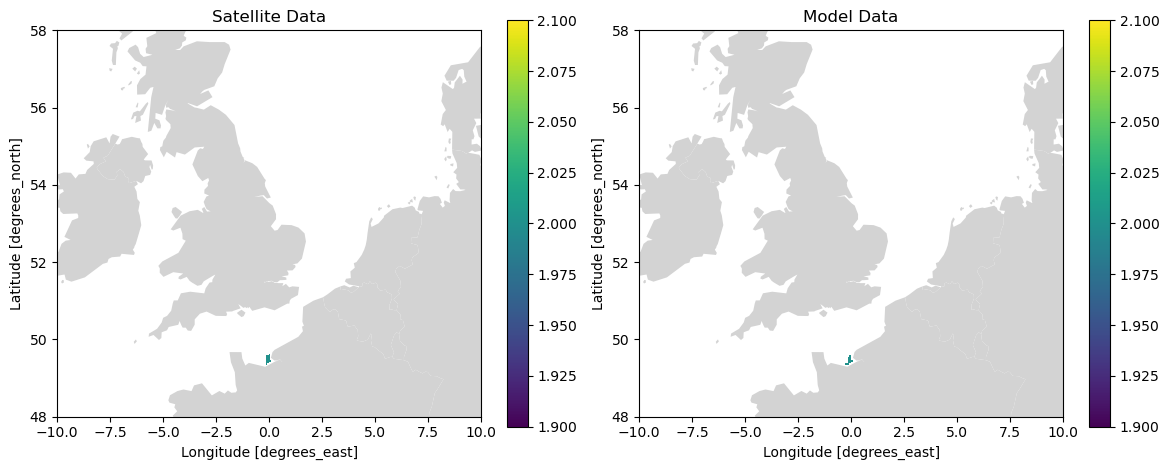

In [249]:
# Plot some matches
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sat_objects_labeled.where(sat_objects_labeled == 2).plot(ax=axes[0])
axes[0].set_title('Satellite Data')
plt.tight_layout()
eu.plot(ax=axes[0], color='lightgrey', linestyle='--')

model_objects_labeled.where((model_objects_labeled) == 2).plot(ax=axes[1])
axes[1].set_title('Model Data')
eu.plot(ax=axes[1], color='lightgrey', linestyle='--')

<Axes: title={'center': 'Model Data'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

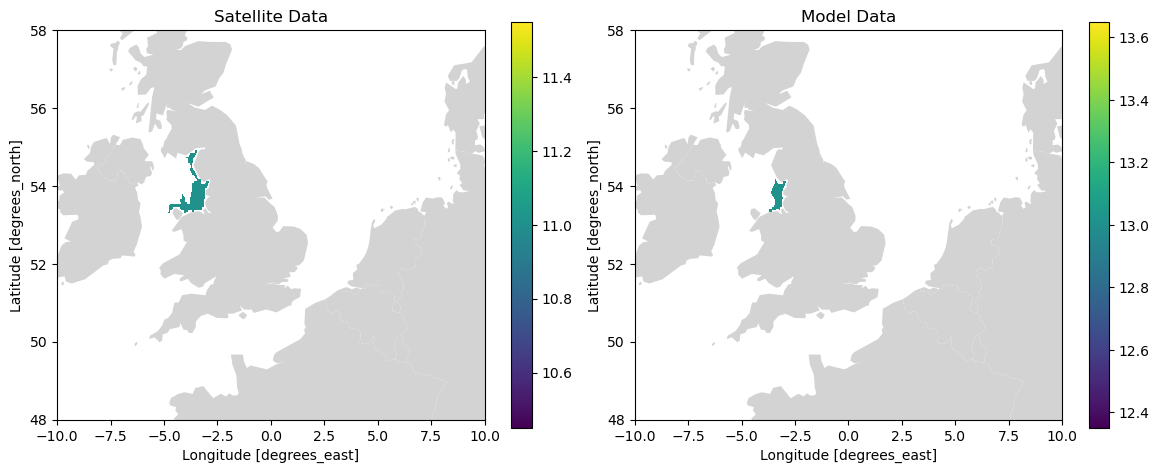

In [256]:
# Plot some matches
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sat_objects_labeled.where(sat_objects_labeled == 11).plot(ax=axes[0])
axes[0].set_title('Satellite Data')
plt.tight_layout()
eu.plot(ax=axes[0], color='lightgrey', linestyle='--')

model_objects_labeled.where((model_objects_labeled) == 13).plot(ax=axes[1])
axes[1].set_title('Model Data')
eu.plot(ax=axes[1], color='lightgrey', linestyle='--')

<Axes: title={'center': 'Model Data'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

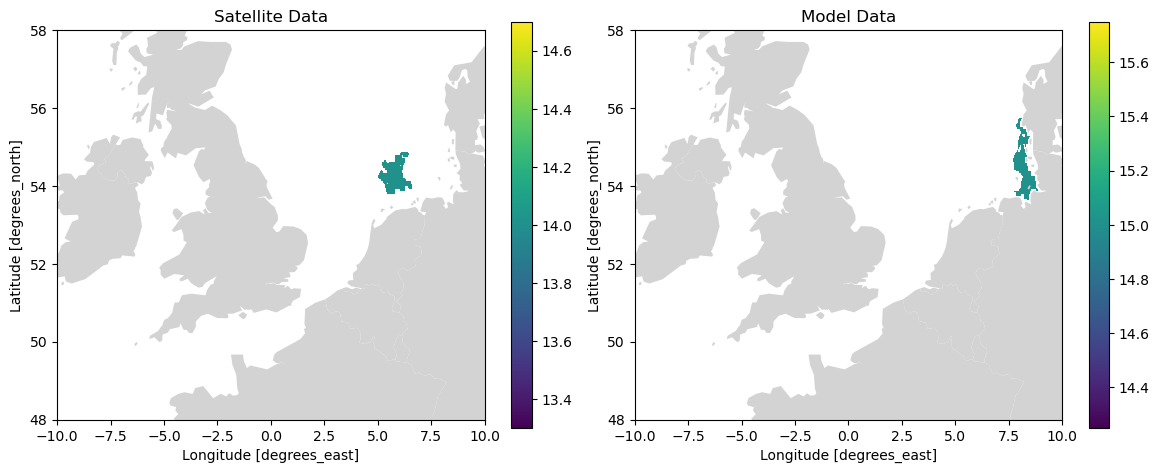

In [257]:
# Plot some matches
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sat_objects_labeled.where(sat_objects_labeled == 14).plot(ax=axes[0])
axes[0].set_title('Satellite Data')
plt.tight_layout()
eu.plot(ax=axes[0], color='lightgrey', linestyle='--')

model_objects_labeled.where((model_objects_labeled) == 15).plot(ax=axes[1])
axes[1].set_title('Model Data')
eu.plot(ax=axes[1], color='lightgrey', linestyle='--')